# Fukui et al. GP hyperparameter optimisation

Here we optimise the GP hyperparameters for the light curves observed by Fukui et al.

We fix the planet's parameters to the values estimated from the previous modelling, but allow the limb darkening to be free. 

In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [22]:
f = pd.HDFStore('data/external_lcs.h5','r')
df = pd.DataFrame([[k]+k.strip('/lc').split('/') for k in f.keys() if 'lc' in k], 
                  columns='key dataset passband name'.split())
df = df[df.dataset == 'fukui2014']

In [23]:
df

,key,dataset,passband,name
11,/lc/fukui2014/H/irsf_130716,fukui2014,H,irsf_130716
12,/lc/fukui2014/H/irsf_130822,fukui2014,H,irsf_130822
13,/lc/fukui2014/H/irsf_131007,fukui2014,H,irsf_131007
14,/lc/fukui2014/J/irsf_130716,fukui2014,J,irsf_130716
15,/lc/fukui2014/J/irsf_130822,fukui2014,J,irsf_130822
16,/lc/fukui2014/J/irsf_131007,fukui2014,J,irsf_131007
17,/lc/fukui2014/J/isle_130813,fukui2014,J,isle_130813
18,/lc/fukui2014/J/isle_130922,fukui2014,J,isle_130922
19,/lc/fukui2014/K/irsf_130716,fukui2014,K,irsf_130716
20,/lc/fukui2014/K/irsf_130822,fukui2014,K,irsf_130822


In [25]:
data = [f[k] for k in df.key]

In [28]:
data[0].keys()

Index([u'flux', u'err', u'airmass', u'sky', u'dx', u'dy', u'oe_mask'], dtype='object')

In [29]:
times = [d.index.values-TZERO for d in data]

In [30]:
times

[array([ 490.456559,  490.456773,  490.457003,  490.457232,  490.457455,
         490.45767 ,  490.457884,  490.458098,  490.458345,  490.458558,
         490.458774,  490.458997,  490.459214,  490.459426,  490.459639,
         490.459886,  490.4601  ,  490.460315,  490.460527,  490.460753,
         490.460967,  490.461187,  490.461404,  490.461618,  490.461834,
         490.462051,  490.462267,  490.46249 ,  490.462714,  490.462956,
         490.463185,  490.4634  ,  490.463612,  490.463824,  490.464038,
         490.464254,  490.464478,  490.46469 ,  490.464905,  490.465128,
         490.465352,  490.465589,  490.465804,  490.466016,  490.466237,
         490.466449,  490.466659,  490.466871,  490.467084,  490.467309,
         490.467521,  490.467734,  490.467944,  490.468157,  490.468371,
         490.468587,  490.468816,  490.46903 ,  490.469261,  490.469473,
         490.469692,  490.469921,  490.470136,  490.470349,  490.470566,
         490.470779,  490.471017,  490.471231,  490

In [17]:
%run core_fukui2014.py

In [3]:
class LPFunctionSingle(object):
    def __init__(self, ilc, nthreads=2):
        self.tm = MA(interpolate=False, nthr=nthreads) 
        self.nt = nthreads

        ## Load data
        ## ---------
        f = pd.HDFStore('data/external_lcs.h5','r')
        hnames = [k for k in f.keys() if 'fukui2014/lc' in k]
        dfs = [f[hname] for hname in hnames]
        f.close()
        
        self.pbname  = hnames[ilc]
        self.time    = dfs[ilc].index.values-TZERO
        self.flux    = dfs[ilc].flux.values
        self.airmass = dfs[ilc].airmass.values
        self.npt     = self.flux.size
        self.dx      = dfs[ilc].dx
        self.dy      = dfs[ilc].dy
        self._wrk_ld = zeros(2)
        self.gp_inputs = transpose([self.time,self.dx,self.dy,self.airmass])
        
        self.mp = median(pd.read_hdf('results/external.h5','/ckwn_ldtk/mc').values, 0)
        
        ## Set up LDTk
        ## ------------
        dft = pd.read_hdf('data/external_lcs.h5','/transmission/fukui2014')
        mapping = dict(G='MITSuME_g', H='IRSF_H', I='MITSuME_Ic', J='IRSF_J', K='IRSF_Ks', R='MITSuME_Rc')
        passbands = map(lambda s:mapping[s.split('/')[3]], hnames)
        
        flt = TabulatedFilter(passbands[ilc], dft.index.values, dft[passbands[ilc]].values)
        self.sc = LDPSetCreator([4150,100], [4.6,0.2], [-0.14,0.16], [flt])
        self.lp = self.sc.create_profiles(2000)
        self.lp.set_uncertainty_multiplier(3)
        
        ## Define priors
        ## -------------
        self.priors = [UP(     0,      1,   'q1'),  ##  0  - limb darkening q1
                       UP(     0,      1,   'q2'),  ##  1  - limb darkening q2
                       UP(  -3.5,     -2,   'ta'),  ##  2  - log10 time amplitude
                       UP(     5,     20,  'its'),  ##  3  - inverse time scale
                       UP(  -3.5,     -2,   'pa'),  ##  4  - log10 xy amplitude
                       UP(     1,     50,  'ixs'),  ##  5  - inverse x scale
                       UP(     1,     50,  'iys'),  ##  6  - inverse y scale
                       UP(  -3.5,     -1,   'aa'),  ##  7  - log10 airmass amplitude
                       UP(     1,     50,  'ias'),  ##  8  - inverse airmass scale
                       UP(    -4,     -2,   'wn')]  ##  9  - log10 white noise
        self.ps = PriorSet(self.priors)
        self.gp = FGP()       
  

    def compute_transit(self, pv):
        mp = self.mp
        _a  = as_from_rhop(mp[2], mp[1]) 
        _i  = mt.acos(mp[3]/_a) 
        _k  = sqrt(mp[4])

        a,b = sqrt(pv[0]), 2.*pv[1]
        self._wrk_ld[0] = a*b
        self._wrk_ld[1] = a*(1.-b)

        flux_m = []
        z = of.z_circular(self.time, mp[0], mp[1], _a, _i, self.nt) 
        return self.tm(z, _k, self._wrk_ld)

    
    def compute_lc_model(self, pv):
        return self.compute_transit(pv)


    def log_likelihood(self, pv):
        self.gp.compute(pv[2:], self.gp_inputs)
        flux_m = self.compute_lc_model(pv)
        return self.gp.lnlikelihood(self.flux-flux_m)
    
        
    def __call__(self, pv):
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -inf
        
        return self.ps.c_log_prior(pv) + self.lp.lnlike_qd(self._wrk_ld) + self.log_likelihood(pv)

In [4]:
def fit_hp(ilc=0, npop=50, niter=50):
    lpf = LPFunctionSingle(ilc)
    de  = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True, F=0.5, C=0.5)
    
    ldm, lds = lpf.lp.coeffs_qd()
    u,v = multivariate_normal(ldm[0], diag(lds[0]**2), size=npop).T
    q1,q2 = (u+v)**2, u/(2*(u+v))
    de._population[:,0] = q1
    de._population[:,1] = q2
    
    de.optimize(niter)
    pv = fmin_powell(lambda pv:-lpf(pv), de.minimum_location, disp=False)
    
    flux_m    = lpf.compute_lc_model(pv)
    residuals = lpf.flux-flux_m
    lpf.gp.compute(pv[2:], lpf.gp_inputs)
    prediction = lpf.gp.gp.predict(residuals, lpf.gp_inputs, mean_only=True)
    return pv, lpf.pbname, lpf.time, lpf.flux, flux_m, residuals, prediction

In [6]:
fits= []
for ilc in range(17):
    clear_output(wait=True)
    display(ilc+1)
    fits.append(fit_hp(ilc, 75, 75))

17

In [19]:
f = pd.HDFStore('data/external_lcs.h5','r')
hnames = [k for k in f.keys() if 'fukui2014/lc' in k]
f.close()

lpf = LPFunctionSingle(0)
df = pd.DataFrame([f[0][2:] for f in fits], columns=lpf.ps.names[2:], index=[n[14:].replace('/','_') for n in hnames])
df.to_hdf('data/external_lcs.h5','/fukui2014/gp_hyperparameters')

In [22]:
df = pd.read_hdf('data/external_lcs.h5', '/fukui2014/gp_hyperparameters')

In [20]:
df

,ta,its,pa,ixs,iys,aa,ias,wn
G_oao50_130813,-2.078077,13.447567,-2.551618,25.638838,44.440204,-1.999766,4.169834,-2.000003
G_oao50_130922,-2.741826,18.356519,-2.970795,1.000129,49.800091,-3.497738,1.024138,-2.067812
H_irsf_130716,-2.497250,19.985147,-2.909322,1.000000,1.000000,-3.499999,1.000981,-2.879712
H_irsf_130822,-2.481514,19.980821,-3.281181,1.000000,1.988051,-3.072516,27.479387,-2.800750
H_irsf_131007,-2.407316,16.357859,-3.127505,1.003428,1.000972,-3.499757,1.019879,-2.597580
I_oao50_130813,-2.750090,19.979990,-3.186380,2.551793,1.004684,-3.499646,1.308656,-2.309573
I_oao50_130922,-2.371360,19.999913,-3.500000,49.998011,49.998558,-3.499995,1.000026,-2.397642
J_irsf_130716,-3.271362,5.000993,-2.750002,1.000000,1.000000,-2.804993,1.753451,-2.734662
J_irsf_130822,-2.405945,16.982645,-3.010504,1.002311,1.760577,-3.495038,1.024200,-2.634195
J_irsf_131007,-2.692917,19.991677,-3.240765,5.803334,24.794252,-3.184961,49.931300,-2.583699


In [14]:
gps = [FGP() for i in range(17)]

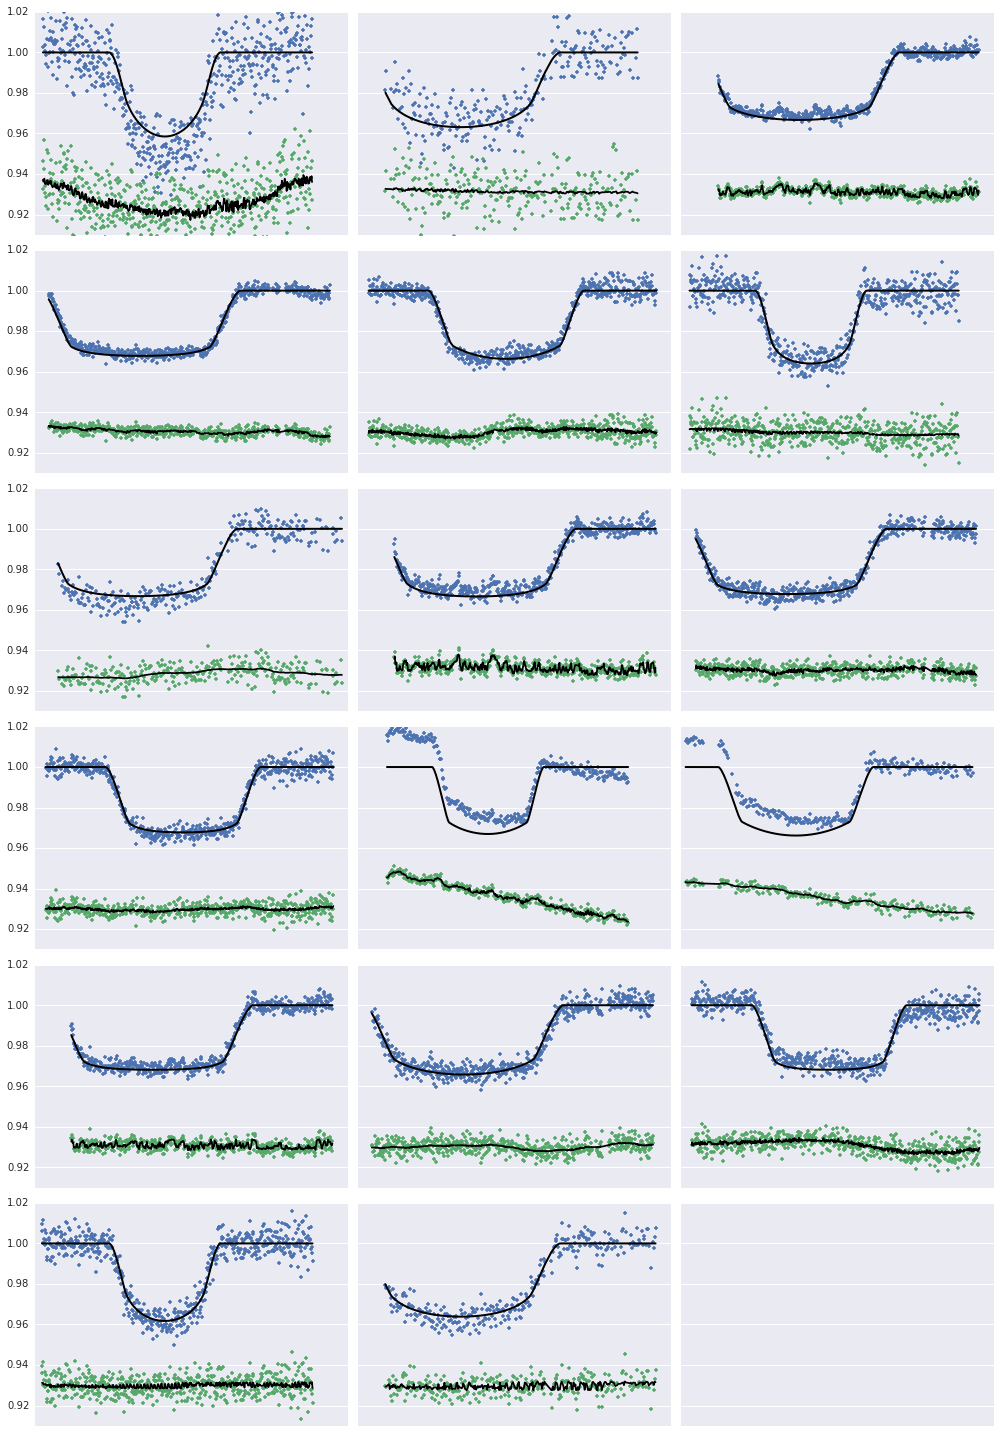

In [16]:
fig,axs = subplots(6,3,figsize=(14,20), sharey=True)
for i in range(17):
    axs.flat[i].plot(fits[i][2], fits[i][3], '.')
    axs.flat[i].plot(fits[i][2], fits[i][4], 'k-', lw=2)
    axs.flat[i].plot(fits[i][2], 0.93+fits[i][5], '.')
    axs.flat[i].plot(fits[i][2], 0.93+fits[i][6], 'k-')
setp(axs, ylim=(0.91,1.02), xticks=[])
fig.tight_layout()